In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../src')

In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend

In [7]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [8]:
%%time
path_figs = './figs/2Mstd5/With_EFF_CALC'
Path(path_figs).mkdir(exist_ok = True, parents = True)
N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
kw_cluster =  {'f_class_name':'circle_class', 'centers': [0.5, 0.5], 'r_small': 0.2, 'r_big':0.4}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [1, std], [1, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000
CPU times: user 71.7 ms, sys: 15 ms, total: 86.7 ms
Wall time: 127 ms


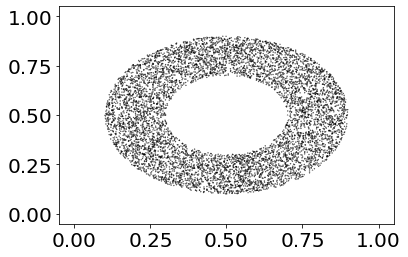

In [9]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [10]:
def box_clustering2(data, clusters = 100,cluster_name ='Box-Cluster',
                   min_support=0, max_support=1, col_select = None, fit_kwargs = {}):
    """
    data: pandas array with data to apply box clustering
    clusters:(number of boxes) clusters
    min_support:(float) the minimum value the box clustering is considering
    max_support:(float) the maximum value the box clustering is considering
    box_length(deprecated):(float) the length of each box
    col_select:[list of strings] names of features to consider for clustering
    
    returns the dataframe with the clustering applied
    """
    values = data[col_select].values
    boxes_per_dim = int(clusters**(1/values.shape[1]))
    box_length = (max_support-min_support)/boxes_per_dim
    grid_length = int((max_support-min_support)/box_length)
    coord_float = np.floor((values-min_support)/box_length).astype('int')
    pivot_array = np.array([grid_length**i for i in range(values.shape[1])])
    index_array = np.sum(coord_float*pivot_array, axis = 1).astype(int)
    
    #values_pd = pd.DataFrame(values, columns = x_names)
    data[cluster_name] = index_array
    
    return data, boxes_per_dim, grid_length, box_length, pivot_array, index_array

In [11]:
tup = box_clustering2(data, clusters = clusters, col_select = ['x0','x1'])

In [12]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 23.9 s, sys: 31.7 ms, total: 23.9 s
Wall time: 23.9 s


In [13]:
data['Box-Cluster'].max()

120

In [14]:
data2 = data.set_index('Box-Cluster').copy()

In [15]:
data2

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
Box-Cluster,,,,,,,,,,
83,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403,0,2.014000,5.957020
61,0.602763,0.544883,0,0,3.046737,10.968478,7.921741,0,7.429187,4.382450
81,0.423655,0.645894,0,0,-12.710297,0.664505,13.374801,0,5.107658,17.817955
103,0.437587,0.891773,1,0,7.349087,5.711404,-1.637683,0,1.011125,-6.337962
54,0.963663,0.383442,0,0,3.842964,3.380475,-0.462489,0,2.418299,-1.424664
...,...,...,...,...,...,...,...,...,...,...
93,0.466430,0.770390,1,1,-2.567938,-0.998147,-1.569790,0,1.316745,-3.884683
42,0.904429,0.317742,0,0,6.347531,4.018538,-2.328993,0,-0.952990,-7.300521
82,0.540895,0.668383,0,0,9.281414,1.676164,-7.605250,0,4.879060,-4.402354


In [16]:
def adaptive_box(data, clusters = 100, cluster_name ='Box-Cluster',ite_old_name = 'ITE', ite_name = 'Adaptive-ite',
                   min_support=0, max_support=1, col_select = None, fit_kwargs = {}):
    
    """
    data: pd.dataFrame with one column containing the box-clustering (box# the datapoint belongs to)
    clusters: number of total boxes in the clustering
    cluster_name: the name of the box clustering column in data
    ite_old_name: name of the current calculated ite for a point
    ite_name: the name the new adaptive ite will take
    min_support: support of the data
    max_support the max support of the data
    col_select: the columns containing the data points
    fit_kwargs: Nothing just for framework consistency
    """
    
    #add the new column to data
    data[ite_name] = 0
    
    #grouped by cluster data
    data_groups = data.set_index(cluster_name).copy()
    
    #take datapoints
    values = data[col_select].values
    dims = values.shape[1]
    #boxes_per_dimension
    grid_length = int(clusters**(1/dims))
    
    #espilon side of the box
    box_length = (max_support-min_support)/grid_length
    
    #array to put (x,y) pair to the correct box number
    pivot_array = np.array([grid_length**i for i in range(dims)])
    
    offset = [-box_length, 0, box_length]
    offset_np = np.zeros([9,2])
    cn = 0
    for offs_x in offset:
        for offs_y in offset:
            offset_np[cn] = np.array([offs_x,offs_y])
            cn += 1
                
    #for each point in data
    for  i, row in enumerate(values):
        #if i%50 == 0:
           # print(i)
        box_numbers = set()
        for offs in offset_np:
            xnew = row + offs
            #support check
            supp_check = all((xnew >= min_support) & (xnew <= max_support))
            if not supp_check:
                continue
            #get box number   
            xnew_grid_coord = np.floor((xnew-min_support)/box_length).astype(int)
            #print(xnew_grid_coord.shape, pivot_array.shape)

            bn = np.sum(xnew_grid_coord*pivot_array).astype(int)

            box_numbers.add(bn)
        
       # print(box_numbers, i)
        candidates = data_groups.loc[box_numbers,col_select+[ite_old_name ]].values
        count = 0
        avg = 0

        for  cand in candidates:
            vals = np.abs(row-cand[0:dims])
            if all(vals <= box_length):
                avg += cand[-1]
                count+=1
        
        new_ite = avg/count
        data.loc[i, ite_name] = new_ite
        
    return data
    

In [17]:
%%time
data = adaptive_box(data, clusters = clusters, ite_old_name = 'ITE-GDBR', col_select = ['x0', 'x1'])

CPU times: user 2min 57s, sys: 38.1 ms, total: 2min 57s
Wall time: 2min 57s


In [18]:
data,_ = kmeans_clustering(data, clusters = 2, cluster_name = 'ITE-ADAPTIVE2',col_select = ['Adaptive-ite'] )

In [19]:
filt = data['ITE-ADAPTIVE2'] == 1
elg = data.loc[filt, 'Adaptive-ite'].mean()
nelg = data.loc[~filt, 'Adaptive-ite'].mean()

data['Fel'] = 0
data.loc[filt,'Fel'] = elg
data.loc[~filt,'Fel'] = nelg

In [20]:
err1 = np.mean(np.abs(data['C'].values-data['Fel'].values))
err1

0.26090342431374525

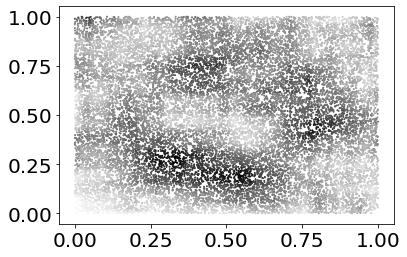

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['Adaptive-ite'], cmap = 'Greys', s = 1)


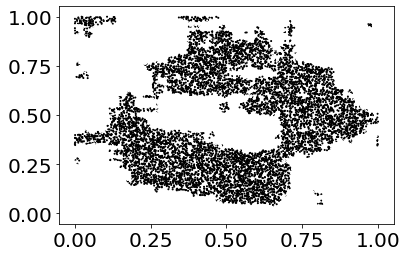

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['ITE-ADAPTIVE2'], cmap = 'Greys', s = 1)


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


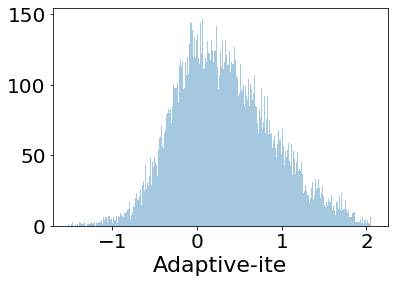

In [23]:
fig, ax = plt.subplots()

ax = sns.distplot(data['Adaptive-ite'],  bins=400, kde = False,ax = ax)
#ax.set_xlim(-2,2)

In [27]:
from econml.metalearners import XLearner as XL

f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

m0 = GDBR(**f1_kwargs)
m1 = GDBR(**f1_kwargs)
t0 = GDBR(**f1_kwargs)
t1 = GDBR(**f1_kwargs)
#g = RF(n_estimators = 400)

model = XL((m0,m1), (t0,t1), categories=[0,1])
xml = model.fit(data.Y, data.Treatment, X = data[['x0','x1']].astype('float32'))

In [28]:
itexml = xml.effect(data[['x0','x1']])

In [29]:
data['ITE-XML'] = itexml
xlearn,_ = kmeans_clustering(data, clusters = 2, cluster_name = 'ITE-XML2',col_select = ['ITE-XML'] )

In [30]:
filt = xlearn['ITE-XML2'] == 1
elg = xlearn.loc[filt, 'ITE-XML'].mean()
nelg = xlearn.loc[~filt, 'ITE-XML'].mean()

xlearn['Fel'] = 0
xlearn.loc[filt,'Fel'] = elg
xlearn.loc[~filt,'Fel'] = nelg

In [31]:
err2 = np.mean(np.abs(xlearn['C'].values-xlearn['Fel'].values))


In [32]:
err2

2.99408440540843

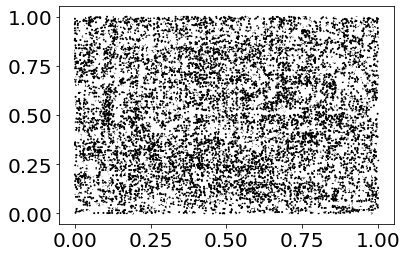

In [33]:
fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['ITE-XML2'], cmap = 'Greys', s = 1)
